### State and Schema

In [69]:
from typing import Dict, List, Optional, Tuple, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
import json
from datetime import datetime
from enum import Enum
import sqlite3
from datetime import datetime, timedelta
import re
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())

from dao.appointment_dao import Appointment
from dao.dao_factory import DAOFactory

class ConversationStage(Enum):

    INITIAL_REQUEST = "initial_request"

    GATHERING_SERVICE_INFO = "gathering_service_info" 
    GATHERING_TIME_PREFERENCES = "gathering_time_preferences"
    GATHERING_CONTACT_INFO = "gathering_contact_info"
    CONFIRMING_DETAILS = "confirming_details"
    
    # for communication with service_match agent
    PROCEED_TO_FETCH_SLOTS = "proceed_to_fetch_slots"
    SLOTS_FETCHED = "slots_fetched"
    NO_SERVICE_AVAILABLE = "no_service_available"
    NO_SLOT_AVAILABLE = "no_slot_available"
    CONFIRMING_SLOTS = "confirming_slots"
    
    # for communication with scheduler/booking agent
    PROCEED_TO_BOOKING = "proceed_to_booking"
    BOOKING_COMPLETE = "booking_complete"

    # for rescheduling/cancelling
    RESCHEDULING = "rescheduling"
    CANCELLING = "cancelling"
    CANCELLEATION_COMPLETE = "cancellation_complete"

class AppointmentState(TypedDict):

    #user details
    user_id: Optional[str]
    user_name: Optional[str]
    
    # Conversation Management
    conversation_stage: ConversationStage = ConversationStage.INITIAL_REQUEST
    messages_history: List[dict]          # Full conversation context among all, user, assistance as well as tools
    chat_history: List[dict]              # the conversation between AI and user that needs to be shown on the UI page
    missing_info: List[str]               # What we still need to collect
    
    # Information Collection (Incremental)
    seeker_request: str                   # Latest message
    service_info: Optional[dict]          # service_type, duration, special_requirements
    time_preferences: Optional[dict]      # preferred_date, preferred_time, flexibility
    seeker_contact: Optional[dict]        # name, email, phone
    location_preference: Optional[str]    # in-person vs online vs no-preference
    
    # AI Processing
    extracted_info: dict                  # Cumulative parsed information
    matched_providers: List[dict]         # Providers with required expertise
    available_slots: List[dict]           # Available time slots
    selected_slot: Optional[dict]         # Final booking choice SLOT
    old_selected_slot: Optional[dict]     # For rescheduling, the old slot to be cancelled

    rescheduling_flag: bool = False  # To indicate if the current flow is for rescheduling
    cancelling_flag: bool = False   # To indicate if the current flow is for cancelling
    booking_attempts: int                 # Number of attempts made to book the appointment

    # Final Booking
    appointment: Optional[int]
    old_appointment: Optional[int]        # For rescheduling/cancelling, the old appointment to be cancelled
    confirmation: Optional[str]          # Booking confirmation details
    meeting_info: Optional[dict]          # Google Meet link or location

    ## agent interaction loop counter
    

### Communication agent

In [70]:


##--------------------------------------------------------------------
#                   NODE
##--------------------------------------------------------------------
def information_gatherer_node(state: AppointmentState) -> AppointmentState:
    """
    Main node that handles conversation flow and information collection ((Communication agent)
    """
    # print(state)
    print("\n\nCommunication agent : ")
    print(state["conversation_stage"])

### --------------------------------------   for information gather, communication with seeker ---------------------------------------
    
    if state['conversation_stage'] in [ConversationStage.INITIAL_REQUEST, ConversationStage.CONFIRMING_DETAILS, ConversationStage.GATHERING_CONTACT_INFO,\
                                       ConversationStage.GATHERING_SERVICE_INFO, ConversationStage.GATHERING_TIME_PREFERENCES]:
        # Initialize Gemini model
        llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                temperature=0,
                                max_tokens=None,
                                timeout=None,
                                max_retries=2)
        
        # Check what information we still need
        missing_info = identify_missing_information(state)
        print("Missing Info: ", missing_info)
        # if not missing_info:
        #     # All required info collected, move to next stage
        #     return {
        #         **state,
        #         "conversation_stage": ConversationStage.PROCEED_TO_FETCH_SLOTS,
        #         "missing_info": []
        #     }
        
        # Extract any new information from the latest message
        extracted_info = extract_information_from_message(state["seeker_request"], llm, state['conversation_stage'])

        print("Extracted Info: ", extracted_info)
        
        # Update state with newly extracted info
        updated_state = update_state_with_extracted_info(state, extracted_info)
        
        # Re-check missing info after extraction
        remaining_missing = identify_missing_information(updated_state)
        print("Remaining State: ", remaining_missing)
        
        if not remaining_missing:
            available_services = DAOFactory().get_service_dao().get_all_service_names()
            print("Available Services: ", available_services)
            # Check if the extracted service type is valid
            if updated_state.get("service_info", {}).get("service_type") is None or updated_state.get("service_info", {}).get("service_type") == "null" or updated_state.get("service_info", {}).get("service_type") not in available_services:
                # No matching service found, inform user
                llm = ChatGoogleGenerativeAI(
                    model="gemini-2.5-flash",
                    temperature=0.3,
                    max_retries=2
                )   
                prompt = f"""
                You are a friendly appointment booking assistant.  
                The user requested a service type that we do not offer: {updated_state.get('service_info', {}).get('service_type')}.  
                Our available services are: {', '.join(available_services)}.  
                Inform the user politely that we do not offer the requested service and ask them to specify a different one.
                Keep the tone polite and conversational.
                """

                response = llm.invoke(prompt)
                follow_up_message = response.content.strip()        
                
                new_messages_history = updated_state.get("messages_history", []).copy()
                new_chat_history =  updated_state.get("chat_history", []).copy()       
                new_messages_history.extend([
                    {"role": "user", "content": state["seeker_request"]},
                    {"role": "assistant", "content": follow_up_message}
                ])
                new_chat_history.extend([
                    {"role": "user", "content": state["seeker_request"],"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
                    {"role": "assistant", "content": follow_up_message, "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
                ])

                return {
                    **updated_state,
                    "messages_history": new_messages_history,
                    "chat_history": new_chat_history,
                    "conversation_stage": ConversationStage.GATHERING_SERVICE_INFO,
                    "missing_info": []
                }
            # All info now complete --> proceed to fetch slots

            llm = ChatGoogleGenerativeAI(
                model="gemini-2.0-flash",   
                temperature=0.3,
                max_retries=2
            )       
            prompt = f"""
            You are a friendly appointment booking assistant.  
            The user has provided all necessary information for booking an appointment:
            - Service type: {updated_state.get('service_info', {}).get('service_type')}
            - Preferred date: {updated_state.get('time_preferences', {}).get('preferred_date')}  

                        Confirm with the user that you will now check for available slots based on their preferences.
            Keep the tone polite and conversational. 
            Here is the chat history for context:
            { ' | '.join([msg["content"] for msg in state.get("chat_history", [])]) }
            """

            follow_up_message = llm.invoke(prompt).content.strip()  

            new_messages_history = updated_state.get("messages_history", []).copy()
            new_chat_history =  updated_state.get("chat_history", []).copy()    
            new_messages_history.extend([
                {"role": "user", "content": state["seeker_request"]},
                {"role": "assistant", "content": follow_up_message}
            ])
            new_chat_history.extend([
                {"role": "user", "content": state["seeker_request"],"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
                {"role": "assistant", "content": follow_up_message, "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
            ])
            return {
                **updated_state,
                "messages_history": new_messages_history,
                "chat_history": new_chat_history,
                "conversation_stage": ConversationStage.PROCEED_TO_FETCH_SLOTS,
                "missing_info": []
            }
        
        # Generate appropriate follow-up question
        follow_up_message = generate_follow_up_question(updated_state, remaining_missing, llm)
        
        # Update conversation history
        new_messages_history = updated_state.get("messages_history", []).copy()
        new_chat_history =  state.get("chat_history", []).copy()
        new_messages_history.extend([
            {"role": "user", "content": state["seeker_request"]},
            {"role": "assistant", "content": follow_up_message}
        ])

        new_chat_history.extend([
            {"role": "user", "content": state["seeker_request"], "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
            {"role": "assistant", "content": follow_up_message, "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
        ])
        
        if remaining_missing[0] == "seeker_contact":
            next_stage = ConversationStage.GATHERING_CONTACT_INFO
        elif remaining_missing[0] == "service_type":
            next_stage = ConversationStage.GATHERING_SERVICE_INFO
        else:
            next_stage = ConversationStage.GATHERING_TIME_PREFERENCES
        return {
            **updated_state,
            "messages_history": new_messages_history,
            "chat_history": new_chat_history,
            "missing_info": remaining_missing,
            "conversation_stage": next_stage
        }


    ##-----------------------------------------     reply on fetched slots   ----------------------------------------

    elif state['conversation_stage'] in [ConversationStage.SLOTS_FETCHED, ConversationStage.CONFIRMING_SLOTS]:
        if state['conversation_stage'] == ConversationStage.SLOTS_FETCHED:
            new_messages_history = state.get("messages_history", []).copy()
            new_chat_history =  state.get("chat_history", []).copy()       
            new_messages_history.extend([
                {"role": "assistant", "content": f"Here are the available slots as per your request : {state['available_slots']}. Please chose one." }
            ])
            new_chat_history.extend([
                {"role": "assistant", "content": f"Here are the available slots as per your request : {state['available_slots']}. Please chose one." , "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
            ])

            return {
                **state,
                "messages_history": new_messages_history,
                "chat_history": new_chat_history,
                "conversation_stage": ConversationStage.CONFIRMING_SLOTS
            }
        else:
            ## Make communication with seeker for confirming from the provided slots , 

                    ## add llm prmpt  for loop conversation on confirming the available slot
            try:        
                selected_slot_id = int(state['seeker_request'])
            except:
                selected_slot_id = None

            ##
            if selected_slot_id == None:
                # put followup message for confirming slot
                new_messages_history = state.get("messages_history", []).copy()
                new_chat_history =  state.get("chat_history", []).copy()       
                new_messages_history.extend([
                    {"role": "user", "content": state["seeker_request"]},
                    {"role": "assistant", "content": f"Could not confirm slot from your input , please choose correct slot..." }
                ])
                new_chat_history.extend([
                    {"role": "user", "content": state["seeker_request"],"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
                    {"role": "assistant", "content": f"Could not confirm slot from your input , please choose correct slot...", "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S") }
                ])

                return {
                    **state,
                    "messages_history": new_messages_history,
                    "chat_history": new_chat_history 
                }

            else:
                ## Proceed to slots_confirmed --> proceed_to_booking
                selected_slot = {}
                for slot in state['available_slots']:
                    if slot['slot_id'] == selected_slot_id:
                        state['selected_slot'] = slot

                new_messages_history = state.get("messages_history", []).copy()
                new_chat_history =  state.get("chat_history", []).copy()       
                new_messages_history.extend([
                    {"role": "user", "content": state["seeker_request"]},
                    {"role": "assistant", "content": f"booking your slot : {state.get('selected_slot','selected_slot_not_found')}." }
                ])
                new_chat_history.extend([
                    {"role": "user", "content": state["seeker_request"],"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
                    {"role": "assistant", "content": f"booking your slot : {state.get('selected_slot','selected_slot_not_found')}.", "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S") }
                ])

                return {
                    **state,
                    "messages_history": new_messages_history,
                    "chat_history": new_chat_history,
                    "conversation_stage": ConversationStage.PROCEED_TO_BOOKING  ### from here the flow will go to booking/scheduler agent 
                }
    ##---------------------------------------- If No SLOTS FOUND, reply accordingly   ---------------------------------------------------
    elif state['conversation_stage'] == ConversationStage.NO_SLOT_AVAILABLE:
        llm = ChatGoogleGenerativeAI(
            model="gemini-2.5-flash",
            temperature=0.3,
            max_tokens=None,
            timeout=None,
            max_retries=2
        )

        # Prepare context
        preferred_date_time = state.get("time_preferences", {})
        chat_summary = " | ".join([msg["content"] for msg in state.get("chat_history", [])[-3:]])  # last 3 exchanges

        # Direct f-string prompt
        prompt = f"""
        You are a friendly appointment booking assistant.  
        The user requested a slot for following time preference :  {preferred_date_time}.  
        Unfortunately, no slots were available.  

        Recent conversation context: {chat_summary}

        Generate a short, natural reply telling the user no slots are available, 
        and ask them to suggest an alternative timing (different date or time range).
        Keep the tone polite and conversational.
        """

        response = llm.invoke(prompt)
        follow_up_message = response.content.strip()

        new_messages_history = state.get("messages_history", []).copy()
        new_chat_history = state.get("chat_history", []).copy()
        new_messages_history.append({"role": "assistant", "content": follow_up_message})
        new_chat_history.append({
            "role": "assistant",
            "content": follow_up_message,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })

        return {
            **state,
            "messages_history": new_messages_history,
            "chat_history": new_chat_history,
            "conversation_stage": ConversationStage.GATHERING_TIME_PREFERENCES  # <-- loop back to asking
        }

    ## For dealing with final booking  stages   
    elif state['conversation_stage'] == ConversationStage.BOOKING_COMPLETE:

        ## give the final message on slot booked by booking/scheduler agent

        new_messages_history = state.get("messages_history", []).copy()
        new_chat_history =  state.get("chat_history", []).copy()       
        new_messages_history.extend([
            {"role": "assistant", "content": f"Successfully booked your slot. Booking confirmation details: {state.get('confirmation','conf_det_not _found')}" }
        ])
        new_chat_history.extend([
            {"role": "assistant", "content": f"Successfully booked your slot. Booking confirmation details: {state.get('confirmation','conf_det_not _found')}" , "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
        ])

        return {
            **state,
            "messages_history": new_messages_history,
            "chat_history": new_chat_history
        }
    
    elif state['conversation_stage'] == ConversationStage.RESCHEDULING:
        # empty the time preference of the state and go to gathering time preference stage
        state['time_preferences'] = {}
        new_messages_history = state.get("messages_history", []).copy()
        new_chat_history =  state.get("chat_history", []).copy()       
        new_messages_history.extend([
            {"role": "assistant", "content": f"Rescheduling your appointment. Please provide new time preferences." }
        ])
        new_chat_history.extend([
            {"role": "assistant", "content": f"Rescheduling your appointment. Please provide new time preferences.", "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
        ])

        state['old_selected_slot'] = state['selected_slot']  # put the old slot in old_selected_slot for cancelling later
        state['old_appointment'] = state['appointment']  # put the old appointment in old_appointment for cancelling later
        return {
            **state,
            "messages_history": new_messages_history,
            "chat_history": new_chat_history,
            "conversation_stage": ConversationStage.GATHERING_TIME_PREFERENCES,
            "rescheduling_flag": True
        }
    
    elif state['conversation_stage'] == ConversationStage.CANCELLING:
        new_messages_history = state.get("messages_history", []).copy()
        new_chat_history =  state.get("chat_history", []).copy()       
        new_messages_history.extend([
            {"role": "assistant", "content": f"Cancelling your appointment. appointment details: {state.get('appointment','appointment_not_found')}" }
        ])
        new_chat_history.extend([
            {"role": "assistant",
             "content": f"Cancelling your appointment. appointment details: {state.get('appointment','appointment_not_found')}",
             "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
        ])

        state['old_appointment'] = state['appointment']  # put the old appointment in old_appointment for cancelling later
        state['old_selected_slot'] = state['selected_slot']  # put the old slot in old_selected_slot for cancelling later
        state['cancelling_flag'] = True
        return {
            **state,
            "messages_history": new_messages_history,
            "chat_history": new_chat_history
        }
    elif state['conversation_stage'] == ConversationStage.CANCELLEATION_COMPLETE:
        new_messages_history = state.get("messages_history", []).copy()
        new_chat_history =  state.get("chat_history", []).copy()       
        new_messages_history.extend([
            {"role": "assistant", "content": f"Successfully cancelled your appointment. appointment details: {state.get('appointment','appointment_not_found')}" }
        ])
        new_chat_history.extend([
            {"role": "assistant",
             "content": f"Successfully cancelled your appointment. appointment details: {state.get('appointment','appointment_not_found')}",
             "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
        ])

        return {
            **state,
            "messages_history": new_messages_history,
            "chat_history": new_chat_history
        }
    ## other scenario  I dont know !!!!!!  :) 
    else:
        return state

def extract_information_from_message(message: str, llm, stage) -> Dict:
    """Extract structured information from user message using Gemini"""
    
    

    if stage == ConversationStage.GATHERING_SERVICE_INFO:
        extraction_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are an expert at extracting appointment booking information.
            Extract the following from the user message and return as JSON:
            
            {{
            "service_type": "extract service type from user request and our available service otherwise put NA",
            "preferred_date": "YYYY-MM-DD format or null (today is {today})",
            "preferred_time": "morning/afternoon/evening/specific time or null",
            "name": "user's name or null", 
            "contact": "phone or email or null",
            "meeting_preference": "online/in-person/no-preference or null",
            "special_requirements": "any specific requests or null"
            }}
            
            - For extracting service type infer from user request which service he/she is trying to get:
            Here are the complete list of services we provide -
            {service_list}
            If there is no information for service type yet,return null.
            If there is info for service type from user but no available service matching user request, put the value as you infer from users request.
            In Later we will inform user that we do not provide the requested service.

            - Be precise with dates. If user says "tomorrow", calculate the actual date.
            If user says "this weekend", extract as null since it's not specific.
            
            Return ONLY valid JSON, no additional text."""),
            ("user", "{message}")
        ])
        
        chain = extraction_prompt | llm
        service_dao = DAOFactory().get_service_dao()
        try:
            service_list = service_dao.get_all_service_names()
        except Exception as e:
            print(f"Service fetch error: {e}")
            service_list = []
        try:
            response = chain.invoke({
                "message": message,
                "service_list": service_list,
                "today": datetime.now().strftime("%Y-%m-%d")
            })
            
            # Clean the response and parse JSON
            content = response.content.strip()
            if content.startswith("```"):
                content = content[7:-3].strip()
            elif content.startswith("```"):
                content = content[3:-3].strip()
                
            return json.loads(content)
        except Exception as e:
            print(f"Extraction error: {e}")
            return {}
    else:
        extraction_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are an expert at extracting appointment booking information.
            Extract the following from the user message and return as JSON:
            
            {{
            "service_type": null,
            "preferred_date": "YYYY-MM-DD format or null (today is {today})",
            "preferred_time": "morning/afternoon/evening/specific time or null",
            "name": "user's name or null", 
            "contact": "phone or email or null",
            "meeting_preference": null,
            "special_requirements": null
            }}
            
            - Be precise with dates. If user says "tomorrow", calculate the actual date.
            If user says "this weekend", extract as null since it's not specific.
            
            Return ONLY valid JSON, no additional text."""),
            ("user", "{message}")
        ])

        chain = extraction_prompt | llm
        
        try:
            response = chain.invoke({
                "message": message,
                "today": datetime.now().strftime("%Y-%m-%d")
            })
            
            # Clean the response and parse JSON
            content = response.content.strip()
            if content.startswith("```"):
                content = content[7:-3].strip()
            elif content.startswith("```"):
                content = content[3:-3].strip()
                
            return json.loads(content)
        except Exception as e:
            print(f"Extraction error: {e}")
            return {}



def identify_missing_information(state: AppointmentState) -> List[str]:
    """Identify what information is still missing"""
    missing = []
    
    # Check required fields
    if not state.get("service_info", {}).get("service_type"):
        missing.append("service_type")
    
    if not state.get("time_preferences", {}).get("preferred_date"):
        missing.append("preferred_date")
        
    if not state.get("seeker_contact", {}).get("name"):
        missing.append("seeker_name")
        
    if not state.get("seeker_contact", {}).get("contact"):
        missing.append("seeker_contact")
    
    return missing

def update_state_with_extracted_info(state: AppointmentState, extracted_info: Dict) -> AppointmentState:
    """Update state with newly extracted information"""
    
    updated_state = state.copy()
    
    # Update service info
    if extracted_info.get("service_type"):
        service_info = updated_state.get("service_info", {})
        service_info["service_type"] = extracted_info["service_type"]
        updated_state["service_info"] = service_info
    
    # Update time preferences
    if extracted_info.get("preferred_date") or extracted_info.get("preferred_time"):
        time_prefs = updated_state.get("time_preferences", {})
        if extracted_info.get("preferred_date"):
            time_prefs["preferred_date"] = extracted_info["preferred_date"]
        if extracted_info.get("preferred_time"):
            time_prefs["preferred_time"] = extracted_info["preferred_time"]
        updated_state["time_preferences"] = time_prefs
    
    # Update contact info
    if extracted_info.get("name") or extracted_info.get("contact"):
        contact_info = updated_state.get("seeker_contact", {})
        if extracted_info.get("name"):
            contact_info["name"] = extracted_info["name"]
        if extracted_info.get("contact"):
            contact_info["contact"] = extracted_info["contact"]
        updated_state["seeker_contact"] = contact_info
    
    return updated_state

def generate_follow_up_question(state: AppointmentState, missing_info: List[str], llm) -> str:
    """Generate contextual follow-up question based on missing information"""
    
    question_map = {
        "service_type": "What type of service are you looking for?",
        "preferred_date": "What date would work best for you?",
        "seeker_name": "Could I get your name for the appointment?",
        "seeker_contact": "How can we reach you to confirm the appointment? (email or phone)"
    }
    
    # Get the most important missing piece
    next_question = question_map.get(missing_info[0], "Could you provide more details?")
    
    # Add context based on what we already know
    context_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a friendly appointment booking assistant. 
        Generate a natural, conversational follow-up question.
        
        Current conversation context:
        - Service type: {service_type}
        - Preferred date: {preferred_date}  
        - User name: {user_name}
        
        Ask for: {missing_item}
        Base question: {base_question}
        
        Make it natural and friendly, referencing what you already know."""),
        ("user", "Generate the follow-up question")
    ])
    
    chain = context_prompt | llm
    
    try:
        response = chain.invoke({
            "service_type": state.get("service_info", {}).get("service_type", "not specified"),
            "preferred_date": state.get("time_preferences", {}).get("preferred_date", "not specified"),
            "user_name": state.get("seeker_contact", {}).get("name", "not specified"),
            "missing_item": missing_info[0],
            "base_question": next_question
        })
        return response.content
    except:
        return next_question




### Router

In [71]:
####-----------------------------------------------------------------------
#                       ROUTER
####-----------------------------------------------------------------------


# Conditional routing function for LangGraph
def conversation_router(state: AppointmentState) -> str:
    """
    Main routing function for the graph
    """
    stage = state.get("conversation_stage", ConversationStage.INITIAL_REQUEST)
    missing_info = state.get("missing_info", [])
    
    # If we still have missing required info, continue gathering
    if missing_info:
        return "gather_info"
    
    # If we have all info, move to next stage
    if stage == ConversationStage.PROCEED_TO_FETCH_SLOTS:
        return "match_services"
    
    if stage == ConversationStage.SLOTS_FETCHED:
        return "end"
    
    if stage == ConversationStage.PROCEED_TO_BOOKING:
        return "schedule"
    
    if stage == ConversationStage.CANCELLING:
        return "schedule"
    # If booking is complete
    if stage == ConversationStage.BOOKING_COMPLETE:
        return "end"
    
    # Default: gather more info
    return "gather_info"

### Tools node

In [72]:
## ---------- ------------------------------------------------------
#                             TOOL NODES
##------------------------------------------------------------------

from langgraph.prebuilt import ToolNode
from typing import Annotated
from langchain_core.tools import InjectedToolCallId
from langgraph.types import Command
from dao.dao_factory import DAOFactory
from dao.appointment_dao import Appointment
# Initialize DAO
dao_factory = DAOFactory()

from langchain_core.tools import tool

###############################   Tools for slot/service matching agent ################################### 
@tool
def find_available_slots_by_date_overlapping_time_range_tool(
    tool_call_id: Annotated[str, InjectedToolCallId],
    date: str,
    start_time: str,
    end_time: str = None,
    status: str = "available",
    service_name: str = None,
):
    """
    Find available time slots by date and overlapping time range.

    Args:
        date (str): The date in YYYY-MM-DD format.
        start_time (str): Start time in HH:MM format.
        end_time (str, optional): End time in HH:MM format. If not provided, defaults to +1 hour.
        status (str, optional): Slot status to filter by (default "available").
        service_name (str, optional): Filter by service name (case-insensitive, partial match).

    Returns:
        Command: Updates state with available slots, conversation stage, and a ToolMessage.
    """

    availability_dao = dao_factory.get_availability_dao()

    try:
        availability_slots = availability_dao.get_slots_by_date_overlapping_time_range(
            date, start_time, end_time, status, service_name
        )
    except Exception as e:
        print("availability error:", e)
        availability_slots = None

    if availability_slots:
        conv_stage = ConversationStage.SLOTS_FETCHED
        msg_text = f"Found {len(availability_slots)} slots: {availability_slots}"
    else:
        conv_stage = ConversationStage.NO_SLOT_AVAILABLE
        msg_text = "No available slots found."

    print("tool node - call - available slots:", availability_slots)

    return Command(
        update={
            "available_slots": availability_slots,
            "conversation_stage": conv_stage,
            "messages_history": [
                ToolMessage(
                    content=msg_text,
                    tool_call_id=tool_call_id,
                )
            ],
        }
    )


# This node will handle calling your tool when Gemini requests it
tools_node_matcher = ToolNode([find_available_slots_by_date_overlapping_time_range_tool], messages_key="messages_history")


##########################                   Tools for booking agent        ###################################################

# @tool
def book_slot_tool(seeker_id, provider_id, slot_id, scheduled_time, status, type_id=1, notes=None):
    """
    Book a new appointment slot for a seeker with a provider.

    Args:
        seeker_id (int): Unique identifier of the seeker (user/patient) booking the slot.
        provider_id (int): Unique identifier of the provider (doctor/mentor/etc.) with whom the slot is booked.
        slot_id (int): The ID of the availability slot being booked.
        scheduled_time (str): The scheduled appointment time (format: "YYYY-MM-DD HH:MM:SS").
        status (str): Status of the appointment (e.g., 'booked', 'pending', 'confirmed').
        type_id (int, optional): Type of appointment (default=1).
        notes (str, optional): Any additional notes related to the appointment.

    Returns:
        str | Appointment:
            - Returns an Appointment object with the generated appointment ID if successfully created.
            - Returns the string "error in creating appointment" if the insertion fails.

    Usage:
        >>> book_slot_tool(
        ...     seeker_id=101,
        ...     provider_id=55,
        ...     slot_id=3001,
        ...     scheduled_time="2025-09-10 14:30:00",
        ...     status="booked",
        ...     notes="First-time consultation"
        ... )
    """
    appointment_dao = dao_factory.get_appointment_dao()
    curr_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    appointment = Appointment(
        type_id=type_id,
        seeker_id=seeker_id,
        provider_id=provider_id,
        slot_id=slot_id,
        scheduled_time=scheduled_time,
        status=status,
        notes=None,
        created_at=curr_time,
        updated_at=curr_time
    )

    try:
        appointment = appointment_dao.create(appointment)
    except Exception as e:
        return f"error in creating appointment for the slot id : {slot_id}. error : {e}"
    return appointment

# @tool
def cancel_slot_tool(appointment_id: int) -> dict:
    """
    Cancel an existing appointment slot.

    Args:
        appointment_id (int): The unique ID of the appointment to cancel.

    Returns:
        True if the appointment was successfully cancelled, otherwise False.

    Usage:
        - Use when the user explicitly requests to cancel an appointment.
        - Pass the `appointment_id` of the booking they want to cancel.
        - If the appointment exists, it will be marked as "cancelled".
    """
    appointment_dao = dao_factory.get_appointment_dao()
    result = appointment_dao.update(appointment_id, "cancelled")
    if result:
        return True
    else:
        return False    
# @tool
def update_slot_availability_tool(slot_id, status):
    """
    Update the availability status of a specific slot.
    Need to be called immediately after book_slot_tool with the booking info. need to mark the slot as booked.

    Args:
        slot_id (int): Unique identifier of the availability slot to update.
        status (str): New status for the slot (e.g., 'available', 'booked', 'blocked').

    Returns:
        bool | str:
            - Returns True if the slot status was successfully updated.
            - Returns False if no rows were updated (slot not found).
            - Returns an error string if the update operation fails.

    Usage:
        >>> update_slot_availability_tool(slot_id=3001, status="booked")
        True
    """
    availability_dao = dao_factory.get_availability_dao()
    try:
        availability_dao.update_slot_status(slot_id=slot_id, status=status)
    except:
        return f"error in updating slot status for slot id : {slot_id}"


# This node will handle calling your tool when Gemini requests it
# tools_node_scheduler = ToolNode([book_slot_tool,update_slot_availability_tool], messages_key="messages_history")


# ---------------------------
# Tool Output Reducer
# ---------------------------
def matcher_tool_result_handler(state: AppointmentState):
    if state.get("conversation_stage") == ConversationStage.PROCEED_TO_FETCH_SLOTS:
        return {
            **state,    
            "available_slots": [],
            "conversation_stage": ConversationStage.NO_SLOT_AVAILABLE
        }
    else:
        return state

def booking_tool_result_handler(state: AppointmentState):
    """
    Extract tool results (from ToolMessage) and merge into state.
    """
    messages = state.get("messages_history", [])
    tool_message = messages[-1]

    if not isinstance(tool_message, ToolMessage):
        return state

    #else update the state with tool result

    print("last tool message : ", tool_message)
    return {
        **state,
        "available_slots": tool_message.content,  # slots now directly accessible
        "conversation_stage": ConversationStage.BOOKING_COMPLETE,
    }

### Service matcher node

In [73]:
##--------------------------------------------------------------------
#                   NODE
##--------------------------------------------------------------------


def service_matcher_node(state: AppointmentState):

    # print(state)
    print("\n\n service matcher agent : ")
    print(state["conversation_stage"])

    service_info = state.get("service_info", {})
    time_preferences = state.get("time_preferences", {})
    location_preference = state.get("location_preference", "no-preference")

    slots_prompt = f"""
    You are an agent whose job is to find available slots based on their preferences:

    - Service info: {service_info}
    - Time preferences: {time_preferences}
    - Location preference: {location_preference}


    - messages history : {state['messages_history']}


    Look at the **last message** in messages_history.
    - If it contains a tool call to `find_available_slots_by_date_overlapping_time_range_tool`,
        then check the tool's result (available slots).
    - If slots were found (non-empty), output `_end_`.
    - If slots were not found (empty list), output `_end_`.
    - Do **not** call the tool again in these cases.

    """

    llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0).bind_tools([find_available_slots_by_date_overlapping_time_range_tool])

    result = llm.invoke(slots_prompt)

    print(type(result))
    print(result)

    
    return {
        **state,
        "messages_history": state.get("messages_history", []) + [result]
    }




### Booking Node

In [74]:
##--------------------------------------------------------------------
#                   NODE
##--------------------------------------------------------------------

from datetime import datetime

def booking_node(state: AppointmentState) -> AppointmentState:
    """
    Booking node that creates the appointment by invoking tools directly.
    Sequentially calls:
    1. book_slot_tool
    2. update_slot_availability_tool
    """

    print("\n\n booking agent : ")
    print(state["conversation_stage"])
    print(state)

    if state['conversation_stage'] == ConversationStage.CANCELLING:

        # cancel the slot now
        old_appointment_id = state['old_appointment']  # get the old appointment id from old_appointment
        old_slot_id = state['old_selected_slot'].get("slot_id") # get the old slot id from old_selected_slot

        try:
            res = cancel_slot_tool(old_appointment_id)
            print(f"cancelling old appointment {old_appointment_id} result: {res}")
        except Exception as e:
            print(f"Error cancelling old appointment {old_appointment_id}: {e}")

        # now update the old slot to available
        try:
            res = update_slot_availability_tool(old_slot_id, "available")
            print(f"updating old slot {old_slot_id} to available slot table: {res}")
        except Exception as e:
            print(f"Error updating old slot {old_slot_id} to available: {e}")

        confirmation_message = (
        f"  Your appointment has been Cancelled!\n"
        f"- Appointment ID: {old_appointment_id}\n"
                    )
        return {
            **state,
            "confirmation": confirmation_message,
            "conversation_stage": ConversationStage.CANCELLEATION_COMPLETE,
        }    
    
    selected_slot = state.get("selected_slot", {})
    seeker_contact = state.get("seeker_contact", {})

    if not selected_slot or not seeker_contact:
        return {
            **state,
            "error": "Missing information for booking",
            "conversation_stage": ConversationStage.BOOKING_COMPLETE
        }

    seeker_id = state.get("user_id", 5)
    provider_id = selected_slot.get("provider_id")
    slot_id = selected_slot.get("slot_id")
    date = selected_slot.get("date")          # e.g. "2025-08-30"
    start_time = selected_slot.get("start_time")  # e.g. "09:00:00"

    # Combine into proper timestamp
    scheduled_time = datetime.strptime(f"{date} {start_time}", "%Y-%m-%d %H:%M:%S")

    # Book appointment
    appointment = book_slot_tool(
        seeker_id=seeker_id,
        provider_id=provider_id,
        slot_id=slot_id,
        scheduled_time=scheduled_time,
        status="booked",
        notes="Auto-booked via booking agent"
    )

    print(appointment)
    
    if isinstance(appointment, str) and appointment.startswith("error"):
        print(f"booking node :: appointment:: {appointment}")
        return {
            **state,
            "error": appointment,
            "conversation_stage": ConversationStage.BOOKING_COMPLETE
        }

    # Update slot availability
    slot_update = update_slot_availability_tool(slot_id=slot_id, status="booked")

    if isinstance(slot_update, str) and slot_update.startswith("error"):
        print(f"booking node :: slot update:: {slot_update}")
        return {
            **state,
            "error": slot_update,
            "conversation_stage": ConversationStage.BOOKING_COMPLETE
        }

    #Create confirmation message
    confirmation_message = (
        f"  Your appointment has been booked!\n"
        f"- Provider ID: {provider_id}\n"
        f'- Provider Name: {selected_slot.get("provider_name", "NA")}\n'
        f"- Scheduled Time: {scheduled_time}\n"
        f"- Appointment ID: {getattr(appointment, 'id', 'N/A')}"
    )

    if state.get('rescheduling_flag', False):

        # Cancel the old slot now
        old_appointment_id = state['old_appointment']  # get the old appointment id from old_appointment
        old_slot_id = state['old_selected_slot'].get("slot_id")  # get the old slot id from old_selected_slot

        try:
            cancel_slot_tool(old_appointment_id)
        except Exception as e:
            print(f"Error cancelling old appointment {old_appointment_id}: {e}")

        # now update the old slot to available
        try:
            update_slot_availability_tool(old_slot_id, "available")
        except Exception as e:
            print(f"Error updating old slot {old_slot_id} to available: {e}")

        confirmation_message = (
        f"  Your appointment has been Rescheduled!\n"
        f"- Provider ID: {provider_id}\n"
        f'- Provider Name: {selected_slot.get("provider_name", "NA")}\n'
        f"- Scheduled Time: {scheduled_time}\n"
        f"- Appointment ID: {getattr(appointment, 'id', 'N/A')}"
    )


    ## Send notification phone/email by using the tools

        ## If offline


        ## If online

    print(f"booking node :: confirmation message :: {confirmation_message}")
    return {
        **state,
        "appointment": appointment.id,
        "confirmation": confirmation_message,
        "conversation_stage": ConversationStage.BOOKING_COMPLETE,
    }

   
    
    

def create_appointment_record(slot_info: Dict, seeker_contact: Dict, state: AppointmentState) -> Optional[int]:
    """
    Create appointment record in database
    """
    conn = sqlite3.connect('appointment_system.db')
    cursor = conn.cursor()
    
    try:
        query = """
        INSERT INTO appointments (
            provider_id, seeker_name, seeker_contact, service_id, 
            slot_id, start_time, end_time, status, meeting_type, special_requirements
        ) VALUES (?, ?, ?, ?, ?, ?, ?, 'confirmed', ?, ?)
        """
        
        meeting_type = determine_meeting_type(state)
        special_requirements = state.get("service_info", {}).get("special_requirements", "")
        
        cursor.execute(query, (
            slot_info["provider_id"],
            seeker_contact["name"],
            seeker_contact["contact"],
            slot_info.get("service_id"),
            slot_info["slot_id"],
            slot_info["start_time"],
            slot_info["end_time"],
            meeting_type,
            special_requirements
        ))
        
        appointment_id = cursor.lastrowid
        conn.commit()
        return appointment_id
        
    except Exception as e:
        print(f"Database error: {e}")
        conn.rollback()
        return None
    finally:
        conn.close()

def update_slot_availability(slot_id: int, is_booked: bool) -> bool:
    """
    Update slot booking status
    """
    conn = sqlite3.connect('appointment_system.db')
    cursor = conn.cursor()
    
    try:
        cursor.execute(
            "UPDATE availability_slots SET is_booked = ? WHERE id = ?",
            (1 if is_booked else 0, slot_id)
        )
        conn.commit()
        return True
    except:
        conn.rollback()
        return False
    finally:
        conn.close()

def determine_meeting_type(state: AppointmentState) -> str:
    """
    Determine if meeting should be online, in-person, or mixed
    """
    location_pref = state.get("location_preference", "no-preference")
    service_type = state.get("service_info", {}).get("service_type", "").lower()
    
    # Some services must be in-person
    in_person_services = ["haircut", "massage", "dental", "physical therapy"]
    
    for service in in_person_services:
        if service in service_type:
            return "in-person"
    
    # Respect user preference
    if location_pref == "online":
        return "online"
    elif location_pref == "in-person":
        return "in-person"
    
    return "online"  # Default to online

def generate_meeting_info(slot_info: Dict, state: AppointmentState) -> Dict:
    """
    Generate meeting details (Google Meet link or location)
    """
    meeting_type = determine_meeting_type(state)
    
    if meeting_type == "online":
        # Generate Google Meet link (simplified)
        meet_link = f"https://meet.google.com/generated-link-{slot_info['slot_id']}"
        return {
            "type": "online",
            "meeting_link": meet_link,
            "platform": "Google Meet"
        }
    else:
        return {
            "type": "in-person", 
            "address": slot_info.get("location", "Address TBD"),
            "instructions": "Please arrive 10 minutes early"
        }

def create_confirmation_message(appointment_id: int, slot_info: Dict, seeker_contact: Dict, meeting_info: Dict) -> Dict:
    """
    Create confirmation message for the seeker
    """
    start_time = datetime.fromisoformat(slot_info["start_time"])
    
    message = f"""
    ✅ **Appointment Confirmed!**
    
    **Booking ID:** #{appointment_id}
    **Service:** {slot_info['service_name']}
    **Provider:** {slot_info['provider_name']}
    **Date & Time:** {start_time.strftime('%B %d, %Y at %I:%M %p')}
    **Duration:** {slot_info['duration_minutes']} minutes
    **Price:** ${slot_info['price']}
    
    """
    
    if meeting_info["type"] == "online":
        message += f"**Meeting Link:** {meeting_info['meeting_link']}\n"
    else:
        message += f"**Location:** {meeting_info['address']}\n"
        message += f"**Note:** {meeting_info['instructions']}\n"
    
    message += f"\nA confirmation will be sent to {seeker_contact['contact']}"
    
    return {
        "appointment_id": appointment_id,
        "message": message,
        "booking_details": slot_info,
        "contact_info": seeker_contact
    }


### Graph workflow

In [75]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)

def create_appointment_graph():
    """
    Creates the main appointment booking graph
    """
    
    # Create the graph
    workflow = StateGraph(AppointmentState)
    
    # Add nodes
    workflow.add_node("gather_info_agent", information_gatherer_node)
    workflow.add_node("match_services_agent", service_matcher_node)
    workflow.add_node("scheduler_agent", booking_node)


    # Tool nodes
    workflow.add_node("tools_node_matcher", tools_node_matcher)
    workflow.add_node("matcher_tool_result_handler", matcher_tool_result_handler)
    # workflow.add_node("tools_node_scheduler", tools_node_scheduler)
    # workflow.add_node("booking_tool_result_handler", booking_tool_result_handler)

    # Add conditional routing
    workflow.add_conditional_edges(
        "gather_info_agent",
        conversation_router,
        {   
            "gather_info": END,
            "match_services": "match_services_agent", # Move to service matching
            "schedule": "scheduler_agent", # Move to scheduler agent
            "end": END
        }
    )


    ## custom tool condition
    def custom_tool_condition(state):
        ai_message = state["messages_history"][-1] 
        print(isinstance(ai_message, AIMessage))
        print(ai_message)
        return tools_condition(state, messages_key="messages_history")

    ## for match_services_agent----------------- 

    workflow.add_conditional_edges(
    "match_services_agent",
    custom_tool_condition,
    {
        "tools": "tools_node_matcher",      
        "__end__": "matcher_tool_result_handler"
    },
    )
    # After tool execution → return to matcher or next stage
    workflow.add_edge("tools_node_matcher", "match_services_agent")
    workflow.add_edge("matcher_tool_result_handler", "gather_info_agent")
    # Sequential flow after info gathering
    # workflow.add_edge("matcher_tool_result_handler", "gather_info_agent")


    ## for scheduler_agent---------------------------
    # workflow.add_conditional_edges(
    # "scheduler_agent",
    # custom_tool_condition,
    # {
    #     "tools": "tools_node_scheduler",      
    #     "__end__": "gather_info_agent"
    # },
    # )
    # workflow.add_edge("tools_node_scheduler", "scheduler_agent")
    # Sequential flow after info gathering
    # workflow.add_edge("booking_tool_result_handler", "gather_info_agent")

    workflow.add_edge("scheduler_agent", "gather_info_agent")

    
    # Set entry point
    workflow.set_entry_point("gather_info_agent")
    
    return workflow.compile(checkpointer=memory)


In [76]:
graph = create_appointment_graph()

In [77]:
mermaid_code = graph.get_graph(xray=True).draw_mermaid()
print(mermaid_code)


---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	gather_info_agent(gather_info_agent)
	match_services_agent(match_services_agent)
	scheduler_agent(scheduler_agent)
	tools_node_matcher(tools_node_matcher)
	matcher_tool_result_handler(matcher_tool_result_handler)
	__end__([<p>__end__</p>]):::last
	__start__ --> gather_info_agent;
	gather_info_agent -. &nbsp;end&nbsp; .-> __end__;
	gather_info_agent -. &nbsp;match_services&nbsp; .-> match_services_agent;
	gather_info_agent -. &nbsp;schedule&nbsp; .-> scheduler_agent;
	match_services_agent -. &nbsp;__end__&nbsp; .-> matcher_tool_result_handler;
	match_services_agent -. &nbsp;tools&nbsp; .-> tools_node_matcher;
	matcher_tool_result_handler --> gather_info_agent;
	scheduler_agent --> gather_info_agent;
	tools_node_matcher --> match_services_agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



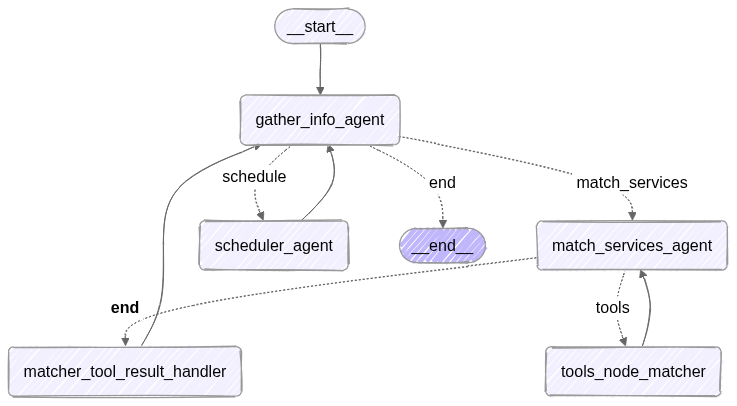

In [78]:
from IPython.display import Image, display 
from langchain_core.runnables.graph import CurveStyle

# Get the raw mermaid string
mermaid_str = graph.get_graph().draw_mermaid(
    curve_style=CurveStyle.BASIS,
    frontmatter_config={ 
        "config": { 
            "theme": "neutral", 
            "look": "handDrawn", 
            "themeVariables": { 
                "primaryColor": "#e2e2e2"
            }
        } 
    }
)

# Replace TD with LR for left-to-right
# mermaid_str_lr = mermaid_str.replace("graph TD;", "graph LR;")

# Display using Mermaid.ink or another service
from langchain_core.runnables.graph_mermaid import draw_mermaid_png
display(Image(draw_mermaid_png(mermaid_str)))


#### Invokes

In [81]:
test_state = {
    "conversation_stage" : ConversationStage.INITIAL_REQUEST,
    "seeker_request" : "Hi there."
}

In [82]:
graph.invoke(test_state, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.INITIAL_REQUEST
Missing Info:  ['service_type', 'preferred_date', 'seeker_name', 'seeker_contact']
Extracted Info:  {'service_type': None, 'preferred_date': None, 'preferred_time': None, 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  ['service_type', 'preferred_date', 'seeker_name', 'seeker_contact']


{'conversation_stage': <ConversationStage.GATHERING_SERVICE_INFO: 'gathering_service_info'>,
 'messages_history': [{'role': 'user', 'content': 'Hi there.'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?'}],
 'chat_history': [{'role': 'user',
   'content': 'Hi there.',
   'timestamp': '2025-09-12 02:48:13'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?',
   'timestamp': '2025-09-12 02:48:13'}],
 'missing_info': ['service_type',
  'preferred_date',
  'seeker_name',
  'seeker_contact'],
 'seeker_request': 'Hi there.'}

In [83]:
graph.invoke({"seeker_request": "I am having a haircut. 14 sep any time is fine"}, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.GATHERING_SERVICE_INFO
Missing Info:  ['service_type', 'preferred_date', 'seeker_name', 'seeker_contact']
connection established succefully
Extracted Info:  {'service_type': 'haircut', 'preferred_date': '2025-09-14', 'preferred_time': None, 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  ['seeker_name', 'seeker_contact']


{'conversation_stage': <ConversationStage.GATHERING_TIME_PREFERENCES: 'gathering_time_preferences'>,
 'messages_history': [{'role': 'user', 'content': 'Hi there.'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?'},
  {'role': 'user',
   'content': 'I am having a haircut. 14 sep any time is fine'},
  {'role': 'assistant',
   'content': 'Great! So for your haircut on September 14th, could I get your name for the appointment?'}],
 'chat_history': [{'role': 'user',
   'content': 'Hi there.',
   'timestamp': '2025-09-12 02:48:13'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?',
   'timestamp': '2025-09-12 02:48:13'},
  {'role': 'user',
   'content': 'I am having a haircut. 14 sep any time is fine',
   'timestamp': '2025-09-12 02:48:43'},
  {'role': 'assistant',
   'content': 'Great! So for your haircut on September 14th, could I get your name for the appointment?',
   'timestamp': '2025-0

In [84]:
graph.invoke({"seeker_request": "I am sumit, 123456 is my phone number"}, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.GATHERING_TIME_PREFERENCES
Missing Info:  ['seeker_name', 'seeker_contact']
Extracted Info:  {'service_type': None, 'preferred_date': None, 'preferred_time': None, 'name': 'sumit', 'contact': '123456', 'meeting_preference': None, 'special_requirements': None}
Remaining State:  []
connection established succefully
Available Services:  ['haircut', 'dentist', 'physiotherapy']


 service matcher agent : 
ConversationStage.PROCEED_TO_FETCH_SLOTS
<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={'function_call': {'name': 'find_available_slots_by_date_overlapping_time_range_tool', 'arguments': '{"date": "2025-09-14", "service_name": "haircut", "start_time": "00:00"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--da872012-acb4-45d5-97e2-bafbeec1afce-0' tool_calls=[{'name': 'find_available_slots_by_da

{'conversation_stage': <ConversationStage.GATHERING_TIME_PREFERENCES: 'gathering_time_preferences'>,
 'messages_history': [ToolMessage(content='No available slots found.', name='find_available_slots_by_date_overlapping_time_range_tool', tool_call_id='3bc1ff99-b24d-4b48-82cd-35535c055ff3'),
  AIMessage(content='_end_', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--5d2aacd3-9e98-4dba-adf8-a1fb7e4d038c-0', usage_metadata={'input_tokens': 504, 'output_tokens': 97, 'total_tokens': 601, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 94}}),
  {'role': 'assistant',
   'content': 'Oh no, Sumit! It looks like September 14th is completely booked up. Would you like to suggest another date or a general time range that might work for your haircut instead?'}],
 'chat_history': [{'role': 'user',
   'content': 'Hi there.',
 

In [85]:
graph.invoke({"seeker_request": "check for whole day"}, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.GATHERING_TIME_PREFERENCES
Missing Info:  []
Extracted Info:  {'service_type': None, 'preferred_date': None, 'preferred_time': None, 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  []
connection established succefully
Available Services:  ['haircut', 'dentist', 'physiotherapy']


 service matcher agent : 
ConversationStage.PROCEED_TO_FETCH_SLOTS
<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={'function_call': {'name': 'find_available_slots_by_date_overlapping_time_range_tool', 'arguments': '{"end_time": "23:59", "date": "2025-09-14", "service_name": "haircut", "start_time": "00:00"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--839cb550-3d3a-48e2-ad56-8a8a9ea2bd2f-0' tool_calls=[{'name': 'find_available_slots_by_date_overlapping_ti

{'conversation_stage': <ConversationStage.CONFIRMING_SLOTS: 'confirming_slots'>,
 'messages_history': [ToolMessage(content="Found 4 slots: [{'slot_id': 14, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(9, 0), 'end_time': datetime.time(10, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}, {'slot_id': 15, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(10, 0), 'end_time': datetime.time(11, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kond

In [86]:
graph.invoke({"seeker_request": "14"}, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.CONFIRMING_SLOTS


 booking agent : 
ConversationStage.PROCEED_TO_BOOKING
{'conversation_stage': <ConversationStage.PROCEED_TO_BOOKING: 'proceed_to_booking'>, 'messages_history': [ToolMessage(content="Found 4 slots: [{'slot_id': 14, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(9, 0), 'end_time': datetime.time(10, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}, {'slot_id': 15, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(10, 0), 'end_time': datetime.time(11, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_p

{'conversation_stage': <ConversationStage.BOOKING_COMPLETE: 'booking_complete'>,
 'messages_history': [ToolMessage(content="Found 4 slots: [{'slot_id': 14, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(9, 0), 'end_time': datetime.time(10, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}, {'slot_id': 15, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(10, 0), 'end_time': datetime.time(11, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kond

In [87]:
graph.invoke({"seeker_request": "reschedule my booking", 'conversation_stage': ConversationStage.RESCHEDULING}, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.RESCHEDULING


{'conversation_stage': <ConversationStage.GATHERING_TIME_PREFERENCES: 'gathering_time_preferences'>,
 'messages_history': [ToolMessage(content="Found 4 slots: [{'slot_id': 14, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(9, 0), 'end_time': datetime.time(10, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}, {'slot_id': 15, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(10, 0), 'end_time': datetime.time(11, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'sa

In [88]:
graph.invoke({"seeker_request": "14 september 3 pm"}, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.GATHERING_TIME_PREFERENCES
Missing Info:  ['preferred_date']
Extracted Info:  {'service_type': None, 'preferred_date': '2025-09-14', 'preferred_time': '3 pm', 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  []
connection established succefully
Available Services:  ['haircut', 'dentist', 'physiotherapy']


 service matcher agent : 
ConversationStage.PROCEED_TO_FETCH_SLOTS
<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={'function_call': {'name': 'find_available_slots_by_date_overlapping_time_range_tool', 'arguments': '{"date": "2025-09-14", "service_name": "haircut", "start_time": "15:00"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--ddc34977-b491-4abc-8223-fb43f467df89-0' tool_calls=[{'name': 'find_available_slots_by_date_overlappi

{'conversation_stage': <ConversationStage.CONFIRMING_SLOTS: 'confirming_slots'>,
 'messages_history': [ToolMessage(content="Found 1 slots: [{'slot_id': 18, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(15, 0), 'end_time': datetime.time(16, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}]", name='find_available_slots_by_date_overlapping_time_range_tool', tool_call_id='012f9c70-257f-41f9-8cc8-2aad83e7a491'),
  AIMessage(content='_end_', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--018dc671-4fe6-4491-ba46-effec94873d5-0', usage_

In [89]:
graph.invoke({"seeker_request": "18"}, config={"configurable": {"thread_id": "86"}})



Communication agent : 
ConversationStage.CONFIRMING_SLOTS


 booking agent : 
ConversationStage.PROCEED_TO_BOOKING
{'conversation_stage': <ConversationStage.PROCEED_TO_BOOKING: 'proceed_to_booking'>, 'messages_history': [ToolMessage(content="Found 1 slots: [{'slot_id': 18, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(15, 0), 'end_time': datetime.time(16, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}]", name='find_available_slots_by_date_overlapping_time_range_tool', tool_call_id='012f9c70-257f-41f9-8cc8-2aad83e7a491'), AIMessage(content='_end_', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'ST

{'conversation_stage': <ConversationStage.BOOKING_COMPLETE: 'booking_complete'>,
 'messages_history': [ToolMessage(content="Found 1 slots: [{'slot_id': 18, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(15, 0), 'end_time': datetime.time(16, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}]", name='find_available_slots_by_date_overlapping_time_range_tool', tool_call_id='012f9c70-257f-41f9-8cc8-2aad83e7a491'),
  AIMessage(content='_end_', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--018dc671-4fe6-4491-ba46-effec94873d5-0', usage_

## New Code

In [93]:
from engine.graph import create_appointment_graph as cgp


In [94]:
graph =  cgp()

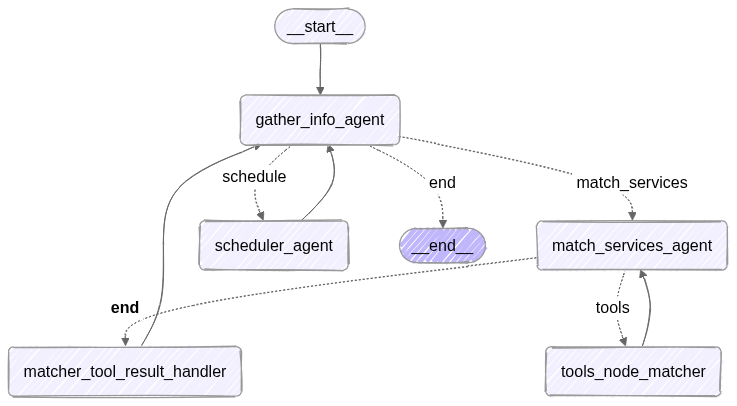

In [95]:
from IPython.display import Image, display 
from langchain_core.runnables.graph import CurveStyle

# Get the raw mermaid string
mermaid_str = graph.get_graph().draw_mermaid(
    curve_style=CurveStyle.BASIS,
    frontmatter_config={ 
        "config": { 
            "theme": "neutral", 
            "look": "handDrawn", 
            "themeVariables": { 
                "primaryColor": "#e2e2e2"
            }
        } 
    }
)

# Replace TD with LR for left-to-right
# mermaid_str_lr = mermaid_str.replace("graph TD;", "graph LR;")

# Display using Mermaid.ink or another service
from langchain_core.runnables.graph_mermaid import draw_mermaid_png
display(Image(draw_mermaid_png(mermaid_str)))


In [96]:
from engine.state import ConversationStage

In [97]:
test_state = {
    "conversation_stage" : ConversationStage.INITIAL_REQUEST,
    "seeker_request" : "Hi there."
}

In [104]:
graph.invoke(test_state, config={"configurable": {"thread_id": "101"}})



Communication agent : 
ConversationStage.INITIAL_REQUEST
Missing Info:  ['service_type', 'preferred_date', 'seeker_name', 'seeker_contact']
Extracted Info:  {'service_type': None, 'preferred_date': None, 'preferred_time': None, 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  ['service_type', 'preferred_date', 'seeker_name', 'seeker_contact']


{'conversation_stage': <ConversationStage.GATHERING_SERVICE_INFO: 'gathering_service_info'>,
 'messages_history': [{'role': 'user', 'content': 'Hi there.'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?'}],
 'chat_history': [{'role': 'user',
   'content': 'Hi there.',
   'timestamp': '2025-09-12 03:48:40'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?',
   'timestamp': '2025-09-12 03:48:40'}],
 'missing_info': ['service_type',
  'preferred_date',
  'seeker_name',
  'seeker_contact'],
 'seeker_request': 'Hi there.'}

In [105]:
graph.invoke({"seeker_request": "I need a haircut"}, config={"configurable": {"thread_id": "101"}})



Communication agent : 
ConversationStage.GATHERING_SERVICE_INFO
Missing Info:  ['service_type', 'preferred_date', 'seeker_name', 'seeker_contact']
connection established succefully
Extracted Info:  {'service_type': 'haircut', 'preferred_date': None, 'preferred_time': None, 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  ['preferred_date', 'seeker_name', 'seeker_contact']


{'conversation_stage': <ConversationStage.GATHERING_TIME_PREFERENCES: 'gathering_time_preferences'>,
 'messages_history': [{'role': 'user', 'content': 'Hi there.'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?'},
  {'role': 'user', 'content': 'I need a haircut'},
  {'role': 'assistant',
   'content': 'Great! What date are you thinking of for your haircut?'}],
 'chat_history': [{'role': 'user',
   'content': 'Hi there.',
   'timestamp': '2025-09-12 03:48:40'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?',
   'timestamp': '2025-09-12 03:48:40'},
  {'role': 'user',
   'content': 'I need a haircut',
   'timestamp': '2025-09-12 03:48:58'},
  {'role': 'assistant',
   'content': 'Great! What date are you thinking of for your haircut?',
   'timestamp': '2025-09-12 03:48:58'}],
 'missing_info': ['preferred_date', 'seeker_name', 'seeker_contact'],
 'seeker_request': 'I need a haircut',
 'se

In [106]:
graph.invoke({"seeker_request": "tomorrow, any time will be fine after 10 am before 5 pm"}, config={"configurable": {"thread_id": "101"}})



Communication agent : 
ConversationStage.GATHERING_TIME_PREFERENCES
Missing Info:  ['preferred_date', 'seeker_name', 'seeker_contact']
Extracted Info:  {'service_type': None, 'preferred_date': '2025-09-13', 'preferred_time': 'after 10 am before 5 pm', 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  ['seeker_name', 'seeker_contact']


{'conversation_stage': <ConversationStage.GATHERING_TIME_PREFERENCES: 'gathering_time_preferences'>,
 'messages_history': [{'role': 'user', 'content': 'Hi there.'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?'},
  {'role': 'user', 'content': 'I need a haircut'},
  {'role': 'assistant',
   'content': 'Great! What date are you thinking of for your haircut?'},
  {'role': 'user',
   'content': 'tomorrow, any time will be fine after 10 am before 5 pm'},
  {'role': 'assistant',
   'content': 'Wonderful! Just to finalize your haircut appointment for September 13th, could I get your name, please?'}],
 'chat_history': [{'role': 'user',
   'content': 'Hi there.',
   'timestamp': '2025-09-12 03:48:40'},
  {'role': 'assistant',
   'content': 'Great! What kind of service are you looking to book today?',
   'timestamp': '2025-09-12 03:48:40'},
  {'role': 'user',
   'content': 'I need a haircut',
   'timestamp': '2025-09-12 03:48:58'},
  {'role': 

In [107]:
graph.invoke({"seeker_request": "Appointment should be under Sumit Vyas and email is smv@gmail.com"}, config={"configurable": {"thread_id": "101"}})



Communication agent : 
ConversationStage.GATHERING_TIME_PREFERENCES
Missing Info:  ['seeker_name', 'seeker_contact']
Extracted Info:  {'service_type': None, 'preferred_date': None, 'preferred_time': None, 'name': 'Sumit Vyas', 'contact': 'smv@gmail.com', 'meeting_preference': None, 'special_requirements': None}
Remaining State:  []
connection established succefully
Available Services:  ['haircut', 'dentist', 'physiotherapy']


 service matcher agent : 
ConversationStage.PROCEED_TO_FETCH_SLOTS
<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={'function_call': {'name': 'find_available_slots_by_date_overlapping_time_range_tool', 'arguments': '{"end_time": "17:00", "date": "2025-09-13", "service_name": "haircut", "start_time": "10:00"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--4819b22e-d290-4563-a17d-0341b6b5c4a6-0' tool_calls=[{'n

{'conversation_stage': <ConversationStage.GATHERING_TIME_PREFERENCES: 'gathering_time_preferences'>,
 'messages_history': [ToolMessage(content='No available slots found.', name='find_available_slots_by_date_overlapping_time_range_tool', tool_call_id='8621ff2f-0677-4483-a7e1-b0ada12d9c29'),
  AIMessage(content='_end_', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--a7453fbb-9bb7-450e-a7a1-6b32206cabee-0', usage_metadata={'input_tokens': 521, 'output_tokens': 98, 'total_tokens': 619, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 95}}),
  {'role': 'assistant',
   'content': "Oh no, Sumit! I've just checked for September 13th between 10 am and 5 pm, and unfortunately, it looks like we're fully booked for that period. Would you like to suggest a different date or perhaps an alternative time that might work for yo

In [108]:
graph.invoke({"seeker_request": "how about 14 september"}, config={"configurable": {"thread_id": "101"}})



Communication agent : 
ConversationStage.GATHERING_TIME_PREFERENCES
Missing Info:  []
Extracted Info:  {'service_type': None, 'preferred_date': '2025-09-14', 'preferred_time': None, 'name': None, 'contact': None, 'meeting_preference': None, 'special_requirements': None}
Remaining State:  []
connection established succefully
Available Services:  ['haircut', 'dentist', 'physiotherapy']


 service matcher agent : 
ConversationStage.PROCEED_TO_FETCH_SLOTS
<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={'function_call': {'name': 'find_available_slots_by_date_overlapping_time_range_tool', 'arguments': '{"end_time": "17:00", "date": "2025-09-14", "service_name": "haircut", "start_time": "10:00"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--ca309d5d-b3e8-4bdf-a230-eae18f7083fb-0' tool_calls=[{'name': 'find_available_slots_by_date_overla

{'conversation_stage': <ConversationStage.CONFIRMING_SLOTS: 'confirming_slots'>,
 'messages_history': [ToolMessage(content="Found 2 slots: [{'slot_id': 15, 'provider_id': 1, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(10, 0), 'end_time': datetime.time(11, 0), 'status': 'available', 'provider_name': 'Aparichit - Hair Stylist', 'provider_email': 'aparichit.stylist@hairsalon.com', 'provider_ph_no': '+1-555-0123', 'provider_pref': {'specialties': ['mens_cuts', 'womens_cuts', 'coloring'], 'salon_location': 'Kondhwa dhumdhakdaka salon', 'experience_years': 8}, 'service_name': 'haircut'}, {'slot_id': 17, 'provider_id': 2, 'date': datetime.date(2025, 9, 14), 'start_time': datetime.time(14, 0), 'end_time': datetime.time(15, 0), 'status': 'available', 'provider_name': 'Darth Vader - Dark Force', 'provider_email': 'darth.vader@starwars.com', 'provider_ph_no': '+91-99999999', 'provider_pref': {'hair_type': 'straight', 'preferred_time': 'morning', 'preferred_style': 'taper'}, 's